# Weather Forecasting Model

## Project Overview
This notebook demonstrates a machine learning approach to weather forecasting using historical temperature data from Buffalo Niagara International Airport. We'll use time series features and compare Linear Regression with Random Forest models.

## Dataset
- **Source**: Buffalo Niagara International Airport (KBUF)
- **Variables**: Temperature, Wind, Pressure, Visibility, and more
- **Objective**: Predict daily temperature using historical patterns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the dataset
df = pd.read_csv('/content/Weather Forecasting Mode/BUFFALO NIAGARA INTERNATIONAL.csv')

# Parse the DATE column
df['DATE'] = pd.to_datetime(df['DATE'])

/tmp/ipython-input-2319290671.py:10: DtypeWarning: Columns (36,37,46,50,51,56,57,59,60,61,62,98,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Weather Forecasting Mode/BUFFALO NIAGARA INTERNATIONAL.csv')


## 1. Data Loading and Preprocessing

Import necessary libraries and load the weather dataset. We'll parse the date column to enable time series analysis.

In [3]:
# Clean the 'TMP' column
# Format is 'temperature_scaled,quality_code'. Split by comma and take the first part.
df['temp_str'] = df['TMP'].astype(str).str.split(',').str[0]

# Replace missing value indicator '+9999' with NaN
df['temp_str'] = df['temp_str'].replace('+9999', np.nan)

# Convert to float and scale down by 10 to get degrees Celsius
df['temperature'] = df['temp_str'].astype(float) / 10.0

# Set Date as index and resample to daily average temperature
df = df.set_index('DATE')
daily_df = df['temperature'].resample('D').mean().to_frame()

## 2. Temperature Data Cleaning

Clean and process the temperature (TMP) column:
- Extract temperature values from the comma-separated format
- Handle missing values (coded as +9999)
- Convert scaled values to degrees Celsius (divide by 10)
- Resample to daily average temperatures

In [4]:
# Create features
daily_df['lag_1'] = daily_df['temperature'].shift(1)
daily_df['lag_2'] = daily_df['temperature'].shift(2)
daily_df['rolling_mean_3'] = daily_df['temperature'].shift(1).rolling(window=3).mean()
daily_df['rolling_mean_7'] = daily_df['temperature'].shift(1).rolling(window=7).mean()

# Drop the first few rows that have NaNs due to shifting/rolling
model_df = daily_df.dropna()

## 3. Feature Engineering

Create time series features for model training:
- **lag_1, lag_2**: Previous days' temperatures
- **rolling_mean_3**: 3-day moving average
- **rolling_mean_7**: 7-day moving average

These features help capture temporal patterns and trends in the temperature data.

In [5]:
# Split data (Time series split, do not shuffle)
train_size = int(len(model_df) * 0.8)
train, test = model_df.iloc[:train_size], model_df.iloc[train_size:]

# Define features (X) and target (y)
X_train = train.drop('temperature', axis=1)
y_train = train['temperature']
X_test = test.drop('temperature', axis=1)
y_test = test['temperature']

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

## 4. Model Training

Split data into training (80%) and testing (20%) sets using chronological order (no shuffling for time series).

Train two regression models:
1. **Linear Regression**: Simple baseline model
2. **Random Forest**: More complex ensemble model that can capture non-linear patterns

Linear Regression MAE: 3.19
Random Forest MAE: 3.93


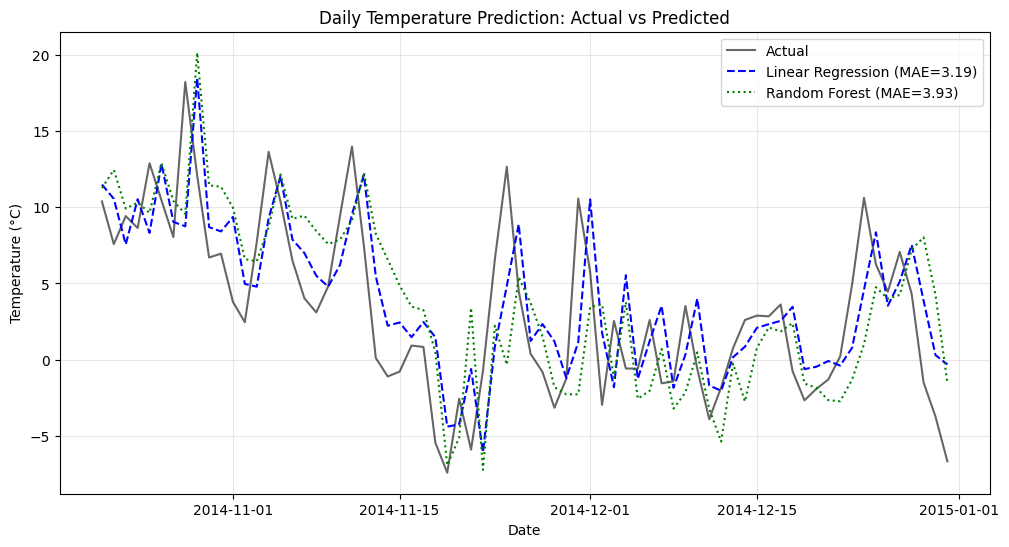

In [6]:
# Calculate Error
lr_mae = mean_absolute_error(y_test, lr_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"Linear Regression MAE: {lr_mae:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black', alpha=0.6)
plt.plot(y_test.index, lr_pred, label=f'Linear Regression (MAE={lr_mae:.2f})', linestyle='--', color='blue')
plt.plot(y_test.index, rf_pred, label=f'Random Forest (MAE={rf_mae:.2f})', linestyle=':', color='green')
plt.title('Daily Temperature Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Model Evaluation and Visualization

Evaluate model performance using Mean Absolute Error (MAE) and visualize the predictions against actual temperature values.

Lower MAE indicates better prediction accuracy.